In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Goiás - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_GO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - Consumo de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,56.459960,97.447,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,56.789152,97.256,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,57.140263,101.442,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,57.649192,98.217,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,58.213295,112.540,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


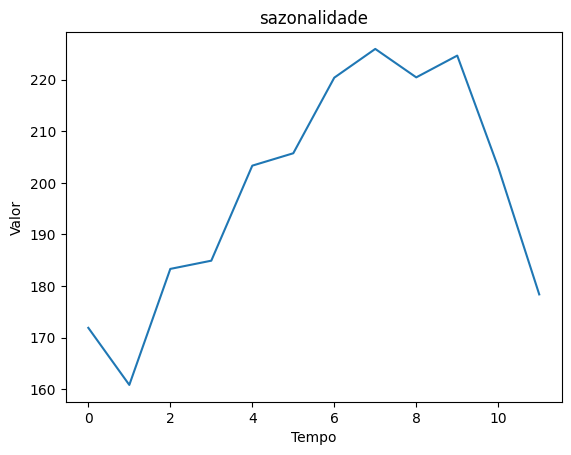

,sazonalidade
sazonalidade,
0,171.893313
1,160.821351
2,183.321109
3,184.916194
4,203.346145
5,205.750017
6,220.410160
7,225.985065
8,220.469640


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Goiás - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás - IDH Longevidade,Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Goiás - Consumo de Cimento (t)
0,2003-1,56.459960,0.706514,0.745293,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,0.775614,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,0.767692,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,171.893313,97.447
1,2003-2,56.789152,0.706866,0.745405,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,0.775902,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,0.767405,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,160.821351,97.256
2,2003-3,57.140263,0.707217,0.745517,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,0.776190,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,0.767117,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,183.321109,101.442
3,2003-4,57.649192,0.707569,0.745629,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,0.776478,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,0.766830,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,184.916194,98.217
4,2003-5,58.213295,0.707920,0.745741,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,0.776766,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,0.766543,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,203.346145,112.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36860.347731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.346145,NaN
257,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36833.247910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.750017,NaN
258,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36770.607054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.410160,NaN
259,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36688.936705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.985065,NaN


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
256        NaN
257        NaN
258        NaN
259        NaN
260        NaN
Name: Goiás - Consumo de Cimento (t), Length: 261, dtype: float64

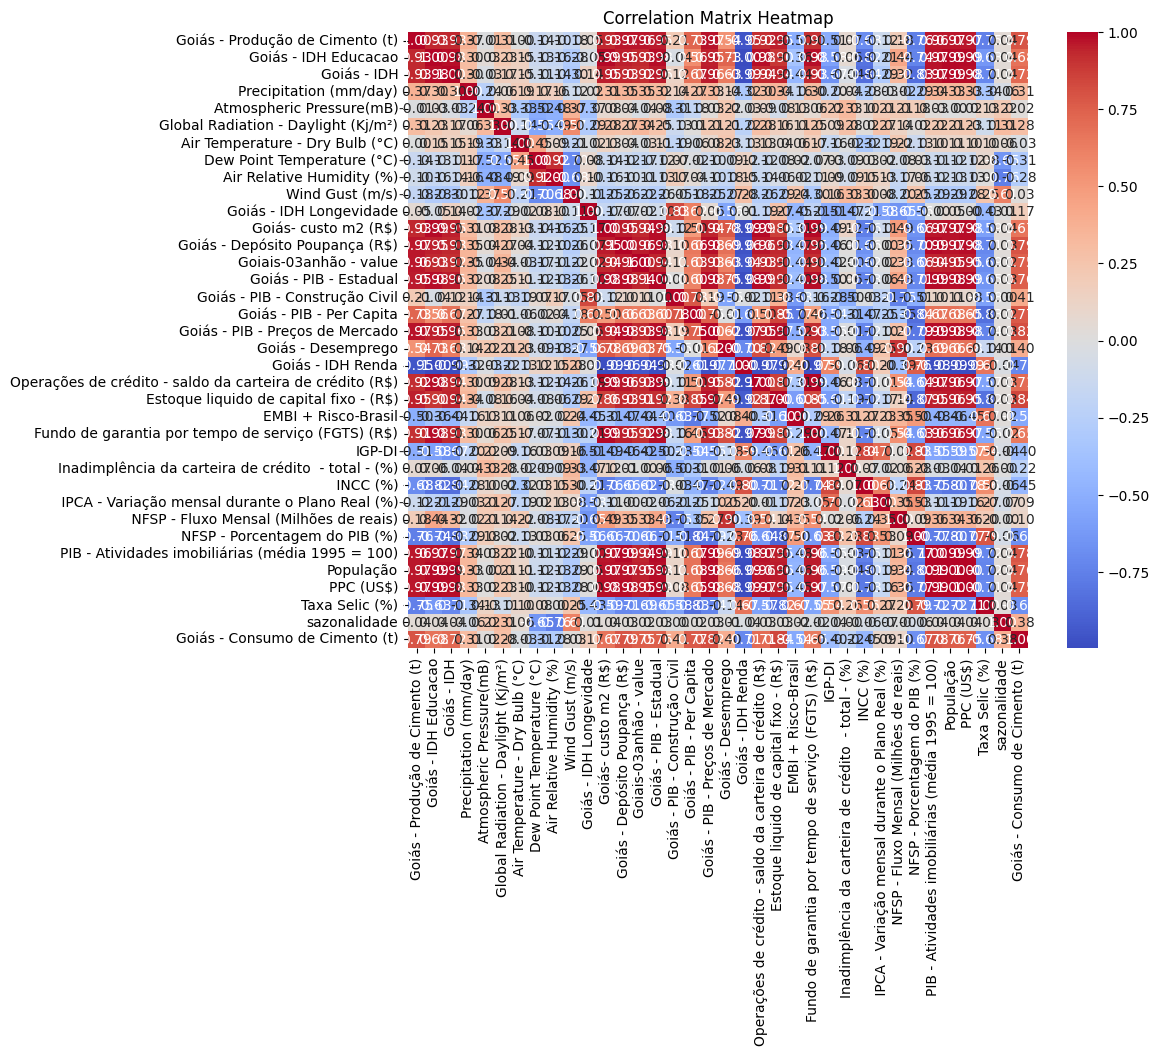

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Goiás - Produção de Cimento (t),4.480357e+03
1,Goiás - IDH Educacao,3.901750e+05
2,Goiás - IDH,4.470962e+08
3,Precipitation (mm/day),2.795385e+00
4,Atmospheric Pressure(mB),9.844027e+00
5,Global Radiation - Daylight (Kj/m²),8.164701e+00
6,Air Temperature - Dry Bulb (°C),9.722850e+01
7,Dew Point Temperature (°C),8.030601e+02
8,Air Relative Humidity (%),7.386938e+02
9,Wind Gust (m/s),2.713844e+01


In [40]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Goiás - Produção de Cimento (t),Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,56.459960,0.706514,2.213042,931.959546,1486.445398,23.971618,18.270239,73.649051,1.213018,10601.325200,3.935260e+06,0.260097,9.371822e+07,5.518325e+06,8.179785,0.767692,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,171.893313
1,56.789152,0.706866,2.021028,932.363097,1483.971093,23.534386,17.704093,73.006649,1.243670,10688.670969,3.962330e+06,0.258964,9.383590e+07,5.523290e+06,8.174086,0.767405,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,160.821351
2,57.140263,0.707217,1.823148,932.798217,1450.427392,22.934067,16.667652,71.378895,1.262206,10770.309117,3.989401e+06,0.257352,9.395358e+07,5.528254e+06,8.168386,0.767117,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,183.321109
3,57.649192,0.707569,1.756117,933.532125,1458.264605,22.346879,15.045930,67.632317,1.355424,10847.723760,4.016472e+06,0.255929,9.407126e+07,5.533219e+06,8.162687,0.766830,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,184.916194
4,58.213295,0.707920,1.331530,934.018275,1466.468143,21.987268,13.454185,63.216002,1.434779,10930.821691,4.043542e+06,0.254109,9.418894e+07,5.538184e+06,8.156988,0.766543,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,203.346145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,134.807122,0.759946,2.333679,932.871076,1512.415228,24.196138,11.593019,51.523052,1.400376,24913.402421,1.110603e+07,0.374870,1.121784e+08,5.556824e+06,8.945274,0.728633,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,225.985065
176,135.642275,0.760068,2.163937,932.224476,1479.994462,24.417553,12.845632,54.954552,1.401896,25013.012903,1.116701e+07,0.375507,1.121578e+08,5.556960e+06,8.940201,0.728666,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,220.469640
177,136.782331,0.760190,2.210665,931.478659,1456.292311,24.504187,14.546376,59.974041,1.278549,25114.241274,1.122799e+07,0.376148,1.121371e+08,5.557097e+06,8.935128,0.728699,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,224.690902
178,137.789488,0.760311,2.362332,931.094998,1415.584125,24.224526,16.058165,65.514227,1.186842,25207.714468,1.128897e+07,0.376801,1.121165e+08,5.557233e+06,8.930055,0.728733,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,1.989930e+08,419.430070,1.004174,203.0182

In [41]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.785087,0.256388,-0.143920,0.926960,0.365288,1.159444,1.242571,-0.574742,-1.471077,-1.503688,-0.886364,-1.663692,-1.837162,-0.335191,1.857980,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.252629
1,-1.762678,-0.101646,0.168942,0.898846,-0.181878,0.895962,1.141099,-0.375227,-1.451452,-1.493304,-0.907289,-1.644951,-1.780760,-0.345766,1.833522,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.772265
2,-1.740270,-0.470617,0.506279,0.517708,-0.933136,0.413607,0.883985,-0.254579,-1.433110,-1.482919,-0.937020,-1.626210,-1.724357,-0.356341,1.809065,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.716293
3,-1.717861,-0.595604,1.075258,0.606758,-1.667961,-0.341137,0.292189,0.352161,-1.415717,-1.472535,-0.963285,-1.607469,-1.667955,-0.366915,1.784608,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.641431
4,-1.695452,-1.387298,1.452157,0.699970,-2.117990,-1.081929,-0.405397,0.868674,-1.397046,-1.462151,-0.996868,-1.588728,-1.611553,-0.377490,1.760151,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.223534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.620090,0.481331,0.562765,1.222041,0.646260,-1.948109,-2.252373,0.644751,1.744520,1.247061,1.231466,1.276227,-1.399784,1.085145,-1.467837,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.286037
176,1.627859,0.164826,0.061473,0.853662,0.923345,-1.365147,-1.710346,0.654645,1.766900,1.270454,1.243232,1.272941,-1.398237,1.075731,-1.464999,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,1.027184
177,1.635628,0.251956,-0.516739,0.584348,1.031762,-0.573627,-0.917485,-0.148206,1.789644,1.293846,1.255063,1.269655,-1.396690,1.066318,-1.462161,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.225299
178,1.643398,0.534757,-0.814181,0.121804,0.681785,0.129953,-0.042377,-0.745119,1.810645,1.317239,1.267112,1.266369,-1.395143,1.056905,-1.459323,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,0.208145


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.785087,0.256388,-0.143920,0.926960,0.365288,1.159444,1.242571,-0.574742,-1.471077,-1.503688,-0.886364,-1.663692,-1.837162,-0.335191,1.857980,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.252629
1,-1.762678,-0.101646,0.168942,0.898846,-0.181878,0.895962,1.141099,-0.375227,-1.451452,-1.493304,-0.907289,-1.644951,-1.780760,-0.345766,1.833522,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.772265
2,-1.740270,-0.470617,0.506279,0.517708,-0.933136,0.413607,0.883985,-0.254579,-1.433110,-1.482919,-0.937020,-1.626210,-1.724357,-0.356341,1.809065,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.716293
3,-1.717861,-0.595604,1.075258,0.606758,-1.667961,-0.341137,0.292189,0.352161,-1.415717,-1.472535,-0.963285,-1.607469,-1.667955,-0.366915,1.784608,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.641431
4,-1.695452,-1.387298,1.452157,0.699970,-2.117990,-1.081929,-0.405397,0.868674,-1.397046,-1.462151,-0.996868,-1.588728,-1.611553,-0.377490,1.760151,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,0.223534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.554436,-1.343221,0.470874,0.643465,0.846985,-0.992250,-1.472477,0.086590,1.499631,0.979509,1.097275,1.284294,-1.325267,1.458473,-1.480014,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.286037
164,1.556689,-0.878331,-0.015662,0.693820,1.153913,-0.483520,-1.032337,0.163436,1.519776,1.000270,1.105888,1.287281,-1.342336,1.396986,-1.481552,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,1.027184
165,1.558943,-0.277151,-0.382535,0.409021,1.030930,0.125463,-0.321004,-0.134049,1.540339,1.021031,1.114449,1.290269,-1.359405,1.335498,-1.483089,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.225299
166,1.561197,-0.201267,-0.555214,0.189325,0.855761,0.519169,0.199234,-0.342042,1.560512,1.041791,1.122956,1.293256,-1.376474,1.274011,-1.484627,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,0.208145


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
163    224.270
164    213.871
165    211.066
166    182.899
167    159.002
Name: Goiás - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 30)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Goiás - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Goiás- custo m2 (R$),Goiás - Depósito Poupança (R$),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,Goiás - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,0.705714,0.748529,-0.509466,0.577888,0.262658,0.961765,1.017479,-1.269000,0.794867,1.368979,0.850601,1.023938,0.362477,1.215921,-0.739336,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,-1.252629
133,0.715715,1.132607,-0.362699,0.243154,-0.168501,0.885303,1.114076,-1.484917,0.816889,1.339390,0.854655,1.036109,0.283781,1.275042,-0.740998,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,-1.772265
134,0.725716,0.644927,0.097972,-0.190277,-0.738295,0.644216,1.061794,-1.561335,0.838906,1.309801,0.858521,1.048279,0.205086,1.334162,-0.742661,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,-0.716293
135,0.735717,0.327744,0.753709,-0.349169,-1.323035,0.100237,0.642268,-1.213976,0.861249,1.280212,0.866037,1.060449,0.126390,1.393282,-0.744323,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,-0.641431
136,0.745718,-0.260766,1.203131,-0.292289,-1.654402,-0.681135,-0.104327,-0.714355,0.883388,1.250623,0.873515,1.072620,0.047695,1.452403,-0.745986,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,0.223534
137,0.755719,0.215561,1.335786,-0.002044,-1.125335,-1.053954,-0.737764,-0.158077,0.905698,1.221034,0.881758,1.084790,-0.031001,1.511523,-0.747648,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,0.336354
138,0.765720,0.872235,1.187681,0.539699,-0.232781,-1.349085,-1.373482,0.304705,0.927776,1.191445,0.896585,1.096961,-0.109696,1.570643,-0.749311,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,1.024393
139,0.775721,0.742194,0.578338,0.860967,0.564234,-1.095592,-1.392706,0.222391,0.953082,1.161856,0.907739,1.109131,-0.188392,1.629764,-0.750973,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,1.286037
140,0.785722,1.293074,0.094211,0.603095,0.975279,-0.521332,-0.906628,-0.082337,0.975494,1.132267,0.918912,1.121302,-0.267087,1.688884,-0.752636,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,1.027184
141,0.795723,0.497711,-0.124714,0.841518,1.219432,-0.175277,-0.617362,-0.255510,0.998347,1.102678,0.930119,1.133472,-0.345783,1.748004,-0.754298,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,1.225299


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [48]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells, 
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=(second_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    
    if second_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(
            second_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells,
                                    want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(sorted(list_loss)[:5])

In [50]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [0, 36, 72, 144]

In [51]:
def hyperparameter_tuning(train_input, train_target, first_layer_cells_list, second_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            print(f"_________________________________________________________________________________________")
            print(" ")
            print(f"Testing [{first_cells}, {second_cells}]")
            print(f"_________________________________________________________________________________________")

            winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                        first_cells, second_cells)
            print(" ")
            print(f"first_layer_n_cells: {first_cells}")
            print(f"second_layer_n_cells: {second_cells}")
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_combination = [first_cells, second_cells, winner_seed]
                print(f"best_loss: {best_loss}")
                print(f"winner_seed: {winner_seed}")
            print(" ")
            
    return best_combination

In [52]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
Testing [36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 297.6705627441406
winner_seed: 1521242827


Step: 1 ___________________________________________
val_loss: 863.9049072265625


Step: 2 ___________________________________________
val_loss: 417.1170959472656


Step: 3 ___________________________________________
val_loss: 582.4686279296875


Step: 4 ___________________________________________
val_loss: 273.27264404296875
winner_seed: 1887579530


Step: 5 ___________________________________________
val_loss: 661.3623046875


Step: 6 ___________________________________________
val_loss: 568.4312744140625


Step: 7 ___________________________________________
val_loss: 368.5500793457031


Step: 8 ___________________________________________
val_loss: 439.17681884765625


Step: 9 _______

val_loss: 491.90911865234375
winner_seed: 319730423


Step: 1 ___________________________________________
val_loss: 718.9010009765625


Step: 2 ___________________________________________
val_loss: 242.68441772460938
winner_seed: 1788507307


Step: 3 ___________________________________________
val_loss: 256.13140869140625


Step: 4 ___________________________________________
val_loss: 806.8180541992188


Step: 5 ___________________________________________
val_loss: 289.3937683105469


Step: 6 ___________________________________________
val_loss: 313.5178527832031


Step: 7 ___________________________________________
val_loss: 359.8113708496094


Step: 8 ___________________________________________
val_loss: 324.99456787109375


Step: 9 ___________________________________________
val_loss: 341.6353759765625
 
first_layer_n_cells: 72
second_layer_n_cells: 144
 
_________________________________________________________________________________________
 
Testing [144, 0]
____________________

2023-11-28 18:06:46.098611: W tensorflow/core/data/root_dataset.cc:286] Optimization loop failed: CANCELLED: Operation was cancelled


val_loss: 420.18609619140625
winner_seed: 1153176574


Step: 1 ___________________________________________
val_loss: 937.6950073242188


Step: 2 ___________________________________________
val_loss: 558.6133422851562


Step: 3 ___________________________________________
val_loss: 387.9214782714844
winner_seed: 3650843124


Step: 4 ___________________________________________
val_loss: 2813.688232421875


Step: 5 ___________________________________________
val_loss: 343.776611328125
winner_seed: 3782455473


Step: 6 ___________________________________________
val_loss: 510.31317138671875


Step: 7 ___________________________________________
val_loss: 1275.6646728515625


Step: 8 ___________________________________________
val_loss: 711.4944458007812


Step: 9 ___________________________________________
val_loss: 545.3744506835938
 
first_layer_n_cells: 144
second_layer_n_cells: 72
 
_________________________________________________________________________________________
 
Testing [144, 

[36, 144, 2208777164]

In [53]:
best_combination

[36, 144, 2208777164]

In [54]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], 
                                    want_verbose=1, 
                                    seed=best_combination[2])

Epoch 1/10000
4/4 [==============================] - 2s 114ms/step - loss: 35388.1719 - val_loss: 1841.9299
Epoch 2/10000
4/4 [==============================] - 0s 7ms/step - loss: 1850.1613 - val_loss: 2292.6650
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 1869.5121 - val_loss: 2621.9514
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 1789.3705 - val_loss: 1878.5261
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 1876.9508 - val_loss: 2258.7168
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 1757.8248 - val_loss: 2158.8193
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 1769.7596 - val_loss: 2035.9723
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 1690.4141 - val_loss: 1095.7510
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 1599.7931 - val_loss: 1434.8629
Epoch 10/10000
4/4 [==============================] 

4/4 [==============================] - 0s 7ms/step - loss: 147.4759 - val_loss: 377.6345
Epoch 158/10000
4/4 [==============================] - 0s 8ms/step - loss: 131.0870 - val_loss: 446.7281
Epoch 159/10000
4/4 [==============================] - 0s 7ms/step - loss: 127.7647 - val_loss: 474.4923
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 134.8047 - val_loss: 379.6399
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 112.8703 - val_loss: 361.5491
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 203.1319 - val_loss: 681.4537
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 150.8211 - val_loss: 291.6856
Epoch 164/10000
4/4 [==============================] - 0s 7ms/step - loss: 180.9578 - val_loss: 431.3528
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 121.4481 - val_loss: 363.8231
Epoch 166/10000
4/4 [==============================] - 0s 10ms/step - l

4/4 [==============================] - 0s 7ms/step - loss: 71.6669 - val_loss: 299.6359
Epoch 314/10000
4/4 [==============================] - 0s 7ms/step - loss: 84.6460 - val_loss: 316.4728
Epoch 315/10000
4/4 [==============================] - 0s 7ms/step - loss: 78.6460 - val_loss: 358.8270
Epoch 316/10000
4/4 [==============================] - 0s 7ms/step - loss: 72.8913 - val_loss: 323.8108
Epoch 317/10000
4/4 [==============================] - 0s 8ms/step - loss: 77.4463 - val_loss: 267.8313
Epoch 318/10000
4/4 [==============================] - 0s 7ms/step - loss: 98.9143 - val_loss: 285.2278
Epoch 319/10000
4/4 [==============================] - 0s 7ms/step - loss: 79.9789 - val_loss: 326.4737
Epoch 320/10000
4/4 [==============================] - 0s 7ms/step - loss: 84.9404 - val_loss: 312.2102
Epoch 321/10000
4/4 [==============================] - 0s 8ms/step - loss: 71.1655 - val_loss: 361.2775
Epoch 322/10000
4/4 [==============================] - 0s 8ms/step - loss: 84.73

Epoch 392/10000
4/4 [==============================] - 0s 7ms/step - loss: 57.2826 - val_loss: 326.2248
Epoch 393/10000
4/4 [==============================] - 0s 7ms/step - loss: 72.5808 - val_loss: 334.8477
Epoch 394/10000
4/4 [==============================] - 0s 8ms/step - loss: 64.9176 - val_loss: 342.3340
Epoch 395/10000
4/4 [==============================] - 0s 7ms/step - loss: 63.2391 - val_loss: 306.2102
Epoch 396/10000
4/4 [==============================] - 0s 7ms/step - loss: 72.1690 - val_loss: 307.5648
Epoch 397/10000
4/4 [==============================] - 0s 7ms/step - loss: 68.2632 - val_loss: 298.4240
Epoch 398/10000
4/4 [==============================] - 0s 7ms/step - loss: 65.5843 - val_loss: 346.2459
Epoch 399/10000
4/4 [==============================] - 0s 7ms/step - loss: 63.5147 - val_loss: 314.4962
Epoch 400/10000
4/4 [==============================] - 0s 7ms/step - loss: 89.5450 - val_loss: 310.4109
Epoch 401/10000
4/4 [==============================] - 0s 7ms/st

Epoch 471/10000
4/4 [==============================] - 0s 7ms/step - loss: 53.1878 - val_loss: 397.3823
Epoch 472/10000
4/4 [==============================] - 0s 7ms/step - loss: 60.8852 - val_loss: 369.7778
Epoch 473/10000
4/4 [==============================] - 0s 7ms/step - loss: 57.9732 - val_loss: 342.0707
Epoch 474/10000
4/4 [==============================] - 0s 7ms/step - loss: 53.5424 - val_loss: 377.3326
Epoch 475/10000
4/4 [==============================] - 0s 7ms/step - loss: 56.4218 - val_loss: 357.4397
Epoch 476/10000
4/4 [==============================] - 0s 7ms/step - loss: 81.5677 - val_loss: 402.3810
Epoch 477/10000
4/4 [==============================] - 0s 7ms/step - loss: 71.0236 - val_loss: 344.3495
Epoch 478/10000
4/4 [==============================] - 0s 7ms/step - loss: 64.9111 - val_loss: 358.3501
Epoch 479/10000
4/4 [==============================] - 0s 7ms/step - loss: 51.1925 - val_loss: 414.4367
Epoch 480/10000
4/4 [==============================] - 0s 8ms/st

Epoch 550/10000
4/4 [==============================] - 0s 7ms/step - loss: 46.8525 - val_loss: 361.0261
Epoch 551/10000
4/4 [==============================] - 0s 7ms/step - loss: 57.6495 - val_loss: 317.3761
Epoch 552/10000
4/4 [==============================] - 0s 7ms/step - loss: 42.8535 - val_loss: 321.2599
Epoch 553/10000
4/4 [==============================] - 0s 7ms/step - loss: 53.3914 - val_loss: 334.3969
Epoch 554/10000
4/4 [==============================] - 0s 7ms/step - loss: 48.3252 - val_loss: 323.4995
Epoch 555/10000
4/4 [==============================] - 0s 8ms/step - loss: 52.9523 - val_loss: 354.0036
Epoch 556/10000
4/4 [==============================] - 0s 7ms/step - loss: 51.9082 - val_loss: 362.3470
Epoch 557/10000
4/4 [==============================] - 0s 8ms/step - loss: 64.9676 - val_loss: 370.2047
Epoch 558/10000
4/4 [==============================] - 0s 7ms/step - loss: 58.6380 - val_loss: 376.0249
Epoch 559/10000
4/4 [==============================] - 0s 7ms/st

Epoch 629/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.4402 - val_loss: 344.1926
Epoch 630/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.5905 - val_loss: 337.9773
Epoch 631/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.8327 - val_loss: 346.0323
Epoch 632/10000
4/4 [==============================] - 0s 7ms/step - loss: 40.4071 - val_loss: 333.4410
Epoch 633/10000
4/4 [==============================] - 0s 7ms/step - loss: 42.2678 - val_loss: 375.5560
Epoch 634/10000
4/4 [==============================] - 0s 7ms/step - loss: 39.1549 - val_loss: 353.8796
Epoch 635/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.0212 - val_loss: 343.6321
Epoch 636/10000
4/4 [==============================] - 0s 7ms/step - loss: 47.0331 - val_loss: 391.7019
Epoch 637/10000
4/4 [==============================] - 0s 8ms/step - loss: 41.4670 - val_loss: 328.2241
Epoch 638/10000
4/4 [==============================] - 0s 7ms/st

Epoch 708/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.9849 - val_loss: 287.3848
Epoch 709/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.3101 - val_loss: 289.8232
Epoch 710/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.0817 - val_loss: 319.1044
Epoch 711/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.6257 - val_loss: 321.2223
Epoch 712/10000
4/4 [==============================] - 0s 7ms/step - loss: 32.6418 - val_loss: 309.0225
Epoch 713/10000
4/4 [==============================] - 0s 7ms/step - loss: 40.4821 - val_loss: 373.0208
Epoch 714/10000
4/4 [==============================] - 0s 7ms/step - loss: 40.2224 - val_loss: 359.0710
Epoch 715/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.8090 - val_loss: 374.9764
Epoch 716/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.3356 - val_loss: 385.8530
Epoch 717/10000
4/4 [==============================] - 0s 8ms/st

Epoch 787/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.8902 - val_loss: 390.4749
Epoch 788/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.0459 - val_loss: 398.4058
Epoch 789/10000
4/4 [==============================] - 0s 10ms/step - loss: 27.0462 - val_loss: 386.5550
Epoch 790/10000
4/4 [==============================] - 0s 8ms/step - loss: 31.2040 - val_loss: 394.6912
Epoch 791/10000
4/4 [==============================] - 0s 8ms/step - loss: 31.1932 - val_loss: 394.6660
Epoch 792/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.8245 - val_loss: 401.5845
Epoch 793/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.1892 - val_loss: 382.2731
Epoch 794/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.7977 - val_loss: 417.6061
Epoch 795/10000
4/4 [==============================] - 0s 7ms/step - loss: 35.1596 - val_loss: 354.3647
Epoch 796/10000
4/4 [==============================] - 0s 7ms/s

Epoch 866/10000
4/4 [==============================] - 0s 7ms/step - loss: 43.5405 - val_loss: 353.8739
Epoch 867/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.8675 - val_loss: 373.7188
Epoch 868/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.4945 - val_loss: 386.2618
Epoch 869/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.5924 - val_loss: 428.1133
Epoch 870/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.5018 - val_loss: 385.5916
Epoch 871/10000
4/4 [==============================] - 0s 8ms/step - loss: 30.3008 - val_loss: 440.1296
Epoch 872/10000
4/4 [==============================] - 0s 7ms/step - loss: 37.8714 - val_loss: 389.2506
Epoch 873/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.0076 - val_loss: 390.2986
Epoch 874/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.5112 - val_loss: 383.7748
Epoch 875/10000
4/4 [==============================] - 0s 7ms/st

Epoch 945/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.2483 - val_loss: 427.9303
Epoch 946/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.4239 - val_loss: 442.7966
Epoch 947/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.8404 - val_loss: 434.7886
Epoch 948/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.8731 - val_loss: 401.0932
Epoch 949/10000
4/4 [==============================] - 0s 7ms/step - loss: 41.2789 - val_loss: 465.4111
Epoch 950/10000
4/4 [==============================] - 0s 7ms/step - loss: 46.7141 - val_loss: 428.1844
Epoch 951/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.3619 - val_loss: 403.9310
Epoch 952/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.2058 - val_loss: 436.2742
Epoch 953/10000
4/4 [==============================] - 0s 7ms/step - loss: 24.3929 - val_loss: 428.6654
Epoch 954/10000
4/4 [==============================] - 0s 7ms/st

In [55]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [56]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,161.442337,165.635895,167.096878,175.487518,198.834763,209.030624,217.005783,224.125214,246.481171,258.635223,251.461288,220.905548
Target,178.918,161.936,173.792,176.627,207.991,185.784,234.176,226.996,218.141,234.939,199.619,168.797
Error,17.475662,3.69989,6.695129,1.139481,9.156235,23.246628,17.170212,2.870789,28.340164,23.696228,51.842285,52.108551


In [57]:
display(mae)
display(mape)

19.786772

0.101650394